# Machine Learning in Python - Group Project 1

**Due Friday, March 10th by 16.00 pm.**

Em Belanger, Alex Chen, Richelle, Robin Siwang Lam

## General Setup

In [1]:
%matplotlib inline
# Add any additional libraries or submodules below

# Data libraries
import numpy as np
import pandas as pd

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80

# sklearn modules that are necessary
import sklearn

# language processing
import nltk

## ML processing libraries
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [2]:
# Load data
data = pd.read_csv("the_office.csv")
lines = pd.read_csv("The-Office-Lines.csv")

After making sure that all the necessary libraries or submodules are uploaded here, please follow the given skeleton to create your project report. 
- Your completed assignment must follow this structure 
- You should not add or remove any of these sections, if you feel it is necessary you may add extra subsections within each (such as *2.1. Encoding*). 

**Do not forget to remove the instructions for each section in the final document.**

## 1. Introduction

*This section should include a brief introduction to the task and the data (assume this is a report you are delivering to a client).* 

- If you use any additional data sources, you should introduce them here and discuss why they were included.

- Briefly outline the approaches being used and the conclusions that you are able to draw.

## 2. Exploratory Data Analysis and Feature Engineering

*Include a detailed discussion of the data with a particular emphasis on the features of the data that are relevant for the subsequent modeling.* 

- Including visualizations of the data is strongly encouraged - all code and plots must also be described in the write up. 
- Think carefully about whether each plot needs to be included in your final draft - your report should include figures but they should be as focused and impactful as possible.

*Additionally, this section should also implement and describe any preprocessing / feature engineering of the data.*

- Specifically, this should be any code that you use to generate new columns in the data frame `d`. All of this processing is explicitly meant to occur before we split the data in to training and testing subsets. 
- Processing that will be performed as part of an sklearn pipeline can be mentioned here but should be implemented in the following section.*

**All code and figures should be accompanied by text that provides an overview / context to what is being done or presented.**

In [3]:
## Have a look at the dataset
data.head()

,season,episode,episode_name,director,writer,imdb_rating,total_votes,air_date,n_lines,n_directions,n_words,n_speak_char,main_chars
0,1,1,Pilot,Ken Kwapis,Ricky Gervais;Stephen Merchant;Greg Daniels,7.6,3706,2005-03-24,229,27,2757,15,Angela;Dwight;Jim;Kevin;Michael;Oscar;Pam;Phyl...
1,1,2,Diversity Day,Ken Kwapis,B.J. Novak,8.3,3566,2005-03-29,203,20,2808,12,Angela;Dwight;Jim;Kelly;Kevin;Michael;Oscar;Pa...
2,1,3,Health Care,Ken Whittingham,Paul Lieberstein,7.9,2983,2005-04-05,244,21,2769,13,Angela;Dwight;Jim;Kevin;Meredith;Michael;Oscar...
3,1,4,The Alliance,Bryan Gordon,Michael Schur,8.1,2886,2005-04-12,243,24,2939,14,Angela;Dwight;Jim;Kevin;Meredith;Michael;Oscar...
4,1,5,Basketball,Greg Daniels,Greg Daniels,8.4,3179,2005-04-19,230,49,2437,18,Angela;Darryl;Dwight;Jim;Kevin;Michael;Oscar;P...


### Data Quality Check

In [4]:
# there is no N/A value in the data
data.isna().any()

season          False
episode         False
episode_name    False
director        False
writer          False
imdb_rating     False
total_votes     False
air_date        False
n_lines         False
n_directions    False
n_words         False
n_speak_char    False
main_chars      False
dtype: bool

In [5]:
# we only have 186 rows, quite a small dataset. so we should keep our model simple to keep from overfitting
data.shape

(186, 13)

### Preliminary Visualisation

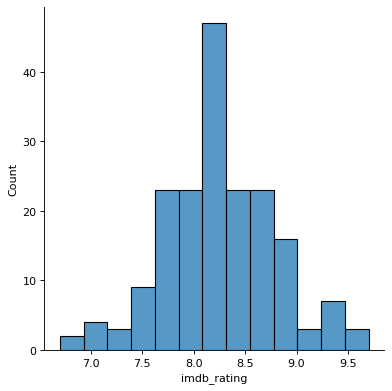

In [6]:
sns.displot(data.imdb_rating)
# the distribution looks like a normal distribution

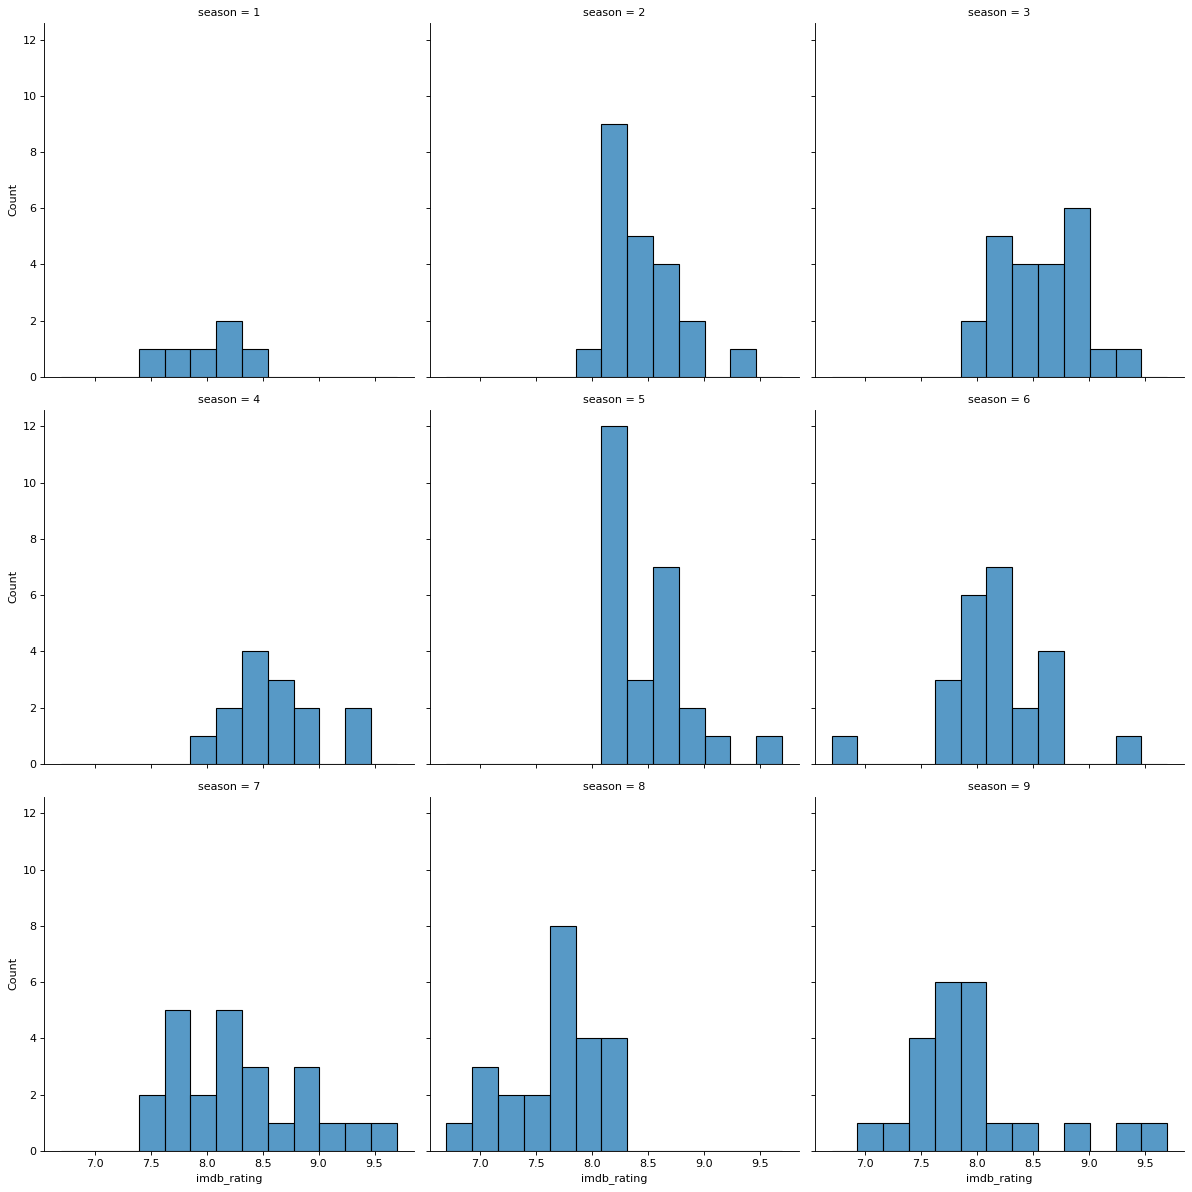

In [8]:
# overall speaking, viewers thought that season 2 and 5 is better, and season 8 is worse than other seasons.
sns.displot(data=data, x='imdb_rating', col='season', col_wrap=3)

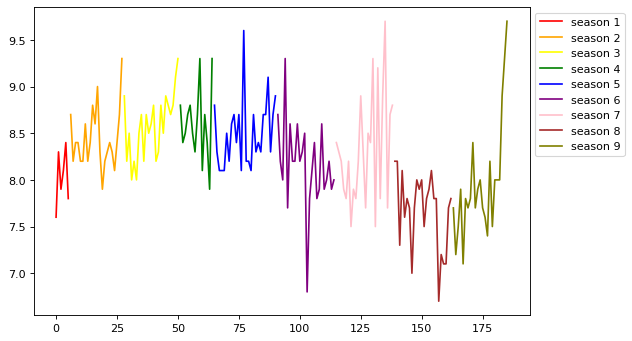

In [9]:
season_color = ['red', 'orange', 'yellow', 'green', 'blue', 'purple', 'pink', 'brown', 'olive']

for i in range(1,10):
    plt.plot(data[data.season == i].index, data[data.season == i].imdb_rating, 
             c=season_color[i-1], label=f'season {i}')
    plt.legend(bbox_to_anchor=(1, 1))

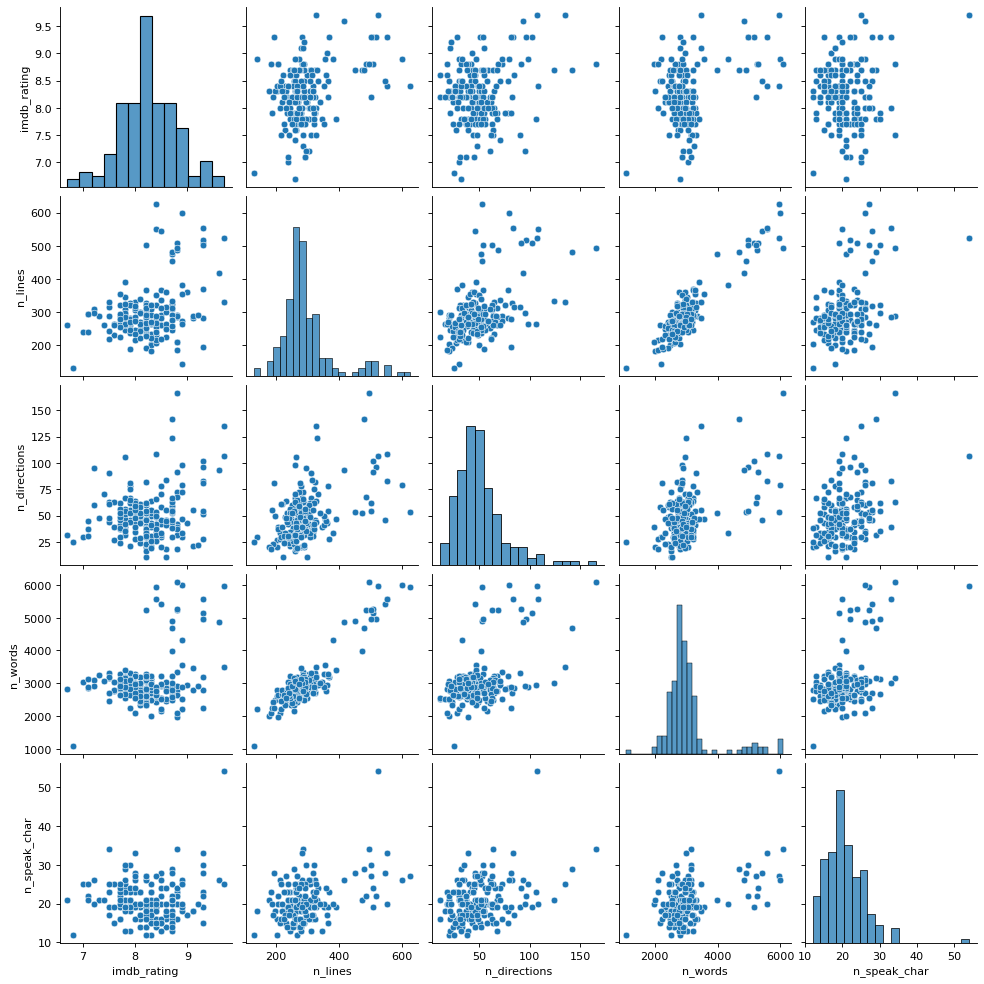

In [276]:
# from the pairplot, it seems that 'total_votes','n_lines','n_directions','n_words','n_speak_char' have positive
# correlation with ratings.
sns.pairplot(data=data.loc[:,['imdb_rating','n_lines','n_directions','n_words','n_speak_char']])

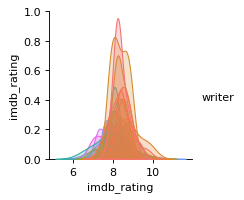

In [296]:
sns.pairplot(data=data.loc[:,['imdb_rating',"writer"]], 
             hue = "writer", plot_kws={"alpha": 0.5})


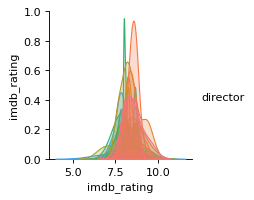

In [295]:
sns.pairplot(data=data.loc[:,['imdb_rating', "director"]], 
             hue = "director", plot_kws={"alpha": 0.5})


### Variable Tidying

In [6]:
data.columns

Index(['season', 'episode', 'episode_name', 'director', 'writer',
       'imdb_rating', 'total_votes', 'air_date', 'n_lines', 'n_directions',
       'n_words', 'n_speak_char', 'main_chars'],
      dtype='object')

Work on the variables 'director', 'writer', 'main_chars'

#### director

In [7]:
# from the results below, we can spot that there are some misspellings
np.sort(data.director.unique())

array(['Alex Hardcastle', 'Amy Heckerling', 'Asaad Kelada', 'B.J. Novak',
       'Brent Forrester', 'Brian Baumgartner', 'Bryan Cranston',
       'Bryan Gordon', 'Charles McDougal', 'Charles McDougall',
       'Charlie Grandy', 'Claire Scanlon', 'Claire Scanlong',
       'Craig Zisk', 'Daniel Chun', 'Danny Leiner', 'David Rogers',
       'Dean Holland', 'Dennie Gordon', 'Ed Helms', 'Eric Appel',
       'Gene Stupnitsky;Lee Eisenberg', 'Greg Daneils', 'Greg Daniels',
       'Harold Ramis', 'J.J. Abrams', 'Jason Reitman', 'Jeffrey Blitz',
       'Jennifer Celotta', 'Jesse Peretz', 'John Krasinski', 'John Scott',
       'Jon Favreau', 'Joss Whedon', 'Julian Farino',
       'Kelly Cantley-Kashima', 'Ken Kwapis', 'Ken Whittingham',
       'Ken Wittingham', 'Lee Eisenberg;Gene Stupnitsky', 'Lee Kirk',
       'Marc Webb', 'Matt Sohn', 'Michael Spiller', 'Miguel Arteta',
       'Mindy Kaling', 'Paul Feig', 'Paul Lieberstein', 'Paul Lieerstein',
       'Rainn Wilson', 'Randall Einhorn', 'Regina

The first is the correct one,

'Charles McDougall'='Charles McDougal'

'Claire Scanlon'='Claire Scanlong'

'Greg Daniels'='Greg Daneils'

'Ken Whittingham'='Ken Wittingham'

'Paul Lieberstein'='Paul Lieerstein'

'Gene Stupnitsky;Lee Eisenberg'='Lee Eisenberg;Gene Stupnitsky' (here we used the order of the first letter)

And there are two pairs of directors: 'Gene Stupnitsky;Lee Eisenberg' and 'Seth Gordon;Harold Ramis'

In [8]:
data.loc[data['director'] == 'Charles McDougal', 'director'] = 'Charles McDougall'
data.loc[data['director'] == 'Claire Scanlong', 'director'] = 'Claire Scanlon'
data.loc[data['director'] == 'Greg Daneils', 'director'] = 'Greg Daniels'
data.loc[data['director'] == 'Ken Wittingham', 'director'] = 'Ken Whittingham'
data.loc[data['director'] == 'Paul Lieerstein', 'director'] = 'Paul Lieberstein'
data.loc[data['director'] == 'Lee Eisenberg;Gene Stupnitsky', 'director'] = 'Gene Stupnitsky;Lee Eisenberg'

#### writer

In [9]:
np.sort(data.writer.unique())

array(['Aaron Shure', 'Allison Silverman', 'Amelie Gillette',
       'Anthony Q. Farrell', 'B.J. Novak', 'Brent Forrester',
       'Brent Forrester;Justin Spitzer', 'Caroline Williams',
       'Carrie Kemper', 'Charlie Grandy', 'Dan Greaney', 'Dan Sterling',
       'Daniel Chun', 'Daniel Chun;Charlie Grandy',
       'Gene Stupnitsky;Lee Eisenberg', 'Graham Wagner', 'Greg Daniels',
       'Greg Daniels;Mindy Kaling', 'Halsted Sullivan;Warren Lieberstein',
       'Jason Kessler', 'Jennifer Celotta',
       'Jennifer Celotta;Greg Daniels',
       'Jennifer Celotta;Paul Lieberstein', 'Jon Vitti',
       'Jonathan Green;Gabe Miller', 'Jonathan Huges', 'Justin Spitzer',
       'Larry Willmore', 'Lee Eisenberg;Gene Stupnitsky',
       'Lee Eisenberg;Gene Stupnitsky;Michael Schur', 'Lester Lewis',
       'Michael Schur', 'Michael Schur;Lee Eisenberg;Gene Stupnitsky',
       'Mindy Kaling', 'Nicki Schwartz-Wright', 'Owen Ellickson',
       'Paul Lieberstein', 'Paul Lieberstein;Michael Schur', '

There are some identical pairs but with different orders,

'Gene Stupnitsky;Lee Eisenberg'='Lee Eisenberg;Gene Stupnitsky'

'Halsted Sullivan;Warren Lieberstein'='Warren Lieberstein;Halsted Sullivan'

'Lee Eisenberg;Gene Stupnitsky;Michael Schur'='Michael Schur;Lee Eisenberg;Gene Stupnitsky'

Here we adopted the first one in each pair.

In [10]:
data.loc[data['writer'] == 'Lee Eisenberg;Gene Stupnitsky', 'writer'] = 'Gene Stupnitsky;Lee Eisenberg'
data.loc[data['writer'] == 'Warren Lieberstein;Halsted Sullivan', 'writer'] = 'Halsted Sullivan;Warren Lieberstein'
data.loc[data['writer'] == 'Michael Schur;Lee Eisenberg;Gene Stupnitsky', 'writer'] = 'Lee Eisenberg;Gene Stupnitsky;Michael Schur'

#### main_chars

In [11]:
# there are too many combinations!
np.sort(data.main_chars.unique())

array(['Andy;Angela;Creed;Darryl;Dwight;Erin;Jim;Kelly;Kevin;Meredith;Michael;Oscar;Pam;Phyllis;Ryan',
       'Andy;Angela;Creed;Darryl;Dwight;Erin;Jim;Kelly;Kevin;Meredith;Michael;Oscar;Pam;Phyllis;Ryan;Stanley',
       'Andy;Angela;Creed;Darryl;Dwight;Erin;Jim;Kelly;Kevin;Meredith;Michael;Oscar;Pam;Phyllis;Ryan;Stanley;Toby',
       'Andy;Angela;Creed;Darryl;Dwight;Erin;Jim;Kelly;Kevin;Meredith;Oscar;Pam;Phyllis;Ryan;Stanley;Toby',
       'Andy;Angela;Creed;Darryl;Dwight;Erin;Jim;Kelly;Kevin;Meredith;Oscar;Pam;Phyllis;Ryan;Toby',
       'Andy;Angela;Creed;Darryl;Dwight;Erin;Jim;Kelly;Kevin;Meredith;Oscar;Pam;Phyllis;Stanley;Toby',
       'Andy;Angela;Creed;Darryl;Dwight;Erin;Jim;Kelly;Kevin;Meredith;Oscar;Phyllis;Ryan;Stanley',
       'Andy;Angela;Creed;Darryl;Dwight;Erin;Jim;Kelly;Kevin;Meredith;Oscar;Phyllis;Ryan;Stanley;Toby',
       'Andy;Angela;Creed;Darryl;Dwight;Erin;Jim;Kelly;Kevin;Michael;Oscar;Pam;Phyllis;Ryan;Stanley',
       'Andy;Angela;Creed;Darryl;Dwight;Erin;Jim;Kelly

From my point of view, because the ultimate goal is to find a combination to produce highest ratings (also interpret the ratings). In this case, some variables are useless, such as `season`, `episode`, `episode_name`(it could be useful but hard to interpret, i.e., what kind of title is eye-attractive), `air_date`. Some needs to be further processed, such as `director`, `writer`, `main_chars`. However, due to the limited dataset, it is impractical to build A SINGLE MODEL to predict what kind of combinations of the directors, the writers, and the main characters produce high-rating episodes (but it is reasonable that certain character is more welcomed to audience, how to put this in a model is quite challenging in this case. maybe we can do some study on what characters are more funny or attractive to the audience via exploratory analysis). One possible way is to analyse whether the numbers of directors/writers/characters have impact on the ratings.

#### Count the number of directors/writers/characters

In [12]:
data.loc[:,'n_director'] = data.director.str.count(';')+1
data.loc[:,'n_writer'] = data.writer.str.count(';')+1
data.loc[:,'n_main_chars'] = data.main_chars.str.count(';')+1

#### Get all the main characters with their occurence (for data visualisation)

In [13]:
# get all the main characters

char_set = set()

for i in data.main_chars.unique():
    temp = i.split(';')
    if char_set == None:
        char_set = set(temp)
    else:
        char_set = char_set | set(temp) # combine two sets to eliminate the duplicated items

In [15]:
char_df = {}

for i in char_set:
    # for each main character, record their occurence and the corresponding ratings
    char_df[i] = data.loc[data.main_chars.str.find(i) != -1, ['season', 'episode', 'imdb_rating']]

At first glance, it seems that there is no main character popular than others. The mean ratings are around 8.25.

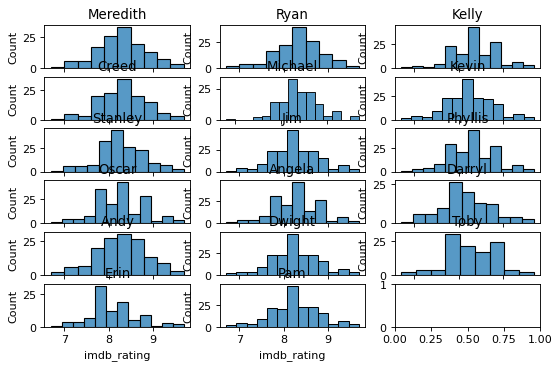

In [17]:
fig, ax = plt.subplots(6,3)

for i, j in enumerate(char_df.keys()):
    sns.histplot(x='imdb_rating', data=char_df[j], ax=ax[i//3, i%3])
    ax[i//3, i%3].set_title(j)

In [18]:
# add one more column to indicate the occurrence of certain character, for future use
for i in char_df.keys():
    char_df[i][f'{i}'] = 1

In [19]:
char_occ = data.loc[:,['season', 'episode']]

In [20]:
for i in char_df.keys():
    char_occ = pd.merge(char_occ, char_df[i][['season','episode',f'{i}']], on=['season', 'episode'], how='left')

In [21]:
char_occ.fillna(0, inplace=True)

In [297]:
char_occ.head()

,season,episode,Meredith,Ryan,Kelly,Creed,Michael,Kevin,Stanley,Jim,Phyllis,Oscar,Angela,Darryl,Andy,Dwight,Toby,Erin,Pam
0,1,1,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1,0.0,0.0,1.0
1,1,2,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1,1.0,0.0,1.0
2,1,3,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1,0.0,0.0,1.0
3,1,4,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1,1.0,0.0,1.0
4,1,5,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1,0.0,0.0,1.0


In [23]:
dir_dummies = pd.get_dummies(data, columns = ["director"])
char_dummies = pd.merge(dir_dummies, char_occ, on=["season", "episode"])
all_dummies = pd.get_dummies(char_dummies, columns = ["writer"])

In [24]:
all_dummies.head()

,season,episode,episode_name,imdb_rating,total_votes,air_date,n_lines,n_directions,n_words,n_speak_char,...,writer_Paul Lieberstein,writer_Paul Lieberstein;Michael Schur,writer_Peter Ocko,writer_Ricky Gervais;Stephen Merchant,writer_Ricky Gervais;Stephen Merchant;Greg Daniels,writer_Robert Padnick,writer_Ryan Koh,writer_Steve Carell,writer_Steve Hely,writer_Tim McAuliffe
0,1,1,Pilot,7.6,3706,2005-03-24,229,27,2757,15,...,0,0,0,0,1,0,0,0,0,0
1,1,2,Diversity Day,8.3,3566,2005-03-29,203,20,2808,12,...,0,0,0,0,0,0,0,0,0,0
2,1,3,Health Care,7.9,2983,2005-04-05,244,21,2769,13,...,1,0,0,0,0,0,0,0,0,0
3,1,4,The Alliance,8.1,2886,2005-04-12,243,24,2939,14,...,0,0,0,0,0,0,0,0,0,0
4,1,5,Basketball,8.4,3179,2005-04-19,230,49,2437,18,...,0,0,0,0,0,0,0,0,0,0


In [298]:
## Get count of number of lines per char per episode

#lines.loc[(lines["speaker"] == "Jim") & (lines["episode"] == 1) & (lines["season"] == 1)].sum()[1]

lines["count"] = 1

count_lines = lines.groupby(by = ["season", "episode", "speaker"], as_index = False).sum()


In [28]:
for i in char_set:
    temp = count_lines.loc[count_lines["speaker"] == i].drop("speaker", axis=1).rename({'count':f'{i}_lines'},
                                                                                       axis='columns')
    all_dummies = pd.merge(all_dummies, temp, on=["season", "episode"], how="outer")

In [29]:
all_dummies.fillna(0, inplace=True)

In [30]:
all_dummies.isna().any().any()

False

In [31]:
all_dummies.head()

,season,episode,episode_name,imdb_rating,total_votes,air_date,n_lines,n_directions,n_words,n_speak_char,...,Jim_lines,Phyllis_lines,Oscar_lines,Angela_lines,Darryl_lines,Andy_lines,Dwight_lines,Toby_lines,Erin_lines,Pam_lines
0,1,1,Pilot,7.6,3706,2005-03-24,229,27,2757,15,...,36.0,2.0,3.0,1.0,0.0,0.0,29.0,0.0,0.0,40.0
1,1,2,Diversity Day,8.3,3566,2005-03-29,203,20,2808,12,...,25.0,0.0,13.0,4.0,0.0,0.0,17.0,2.0,0.0,12.0
2,1,3,Health Care,7.9,2983,2005-04-05,244,21,2769,13,...,42.0,0.0,9.0,5.0,0.0,0.0,62.0,0.0,0.0,32.0
3,1,4,The Alliance,8.1,2886,2005-04-12,243,24,2939,14,...,49.0,5.0,14.0,7.0,0.0,0.0,47.0,4.0,0.0,22.0
4,1,5,Basketball,8.4,3179,2005-04-19,230,49,2437,18,...,21.0,4.0,2.0,3.0,15.0,0.0,25.0,0.0,0.0,14.0


<AxesSubplot:>

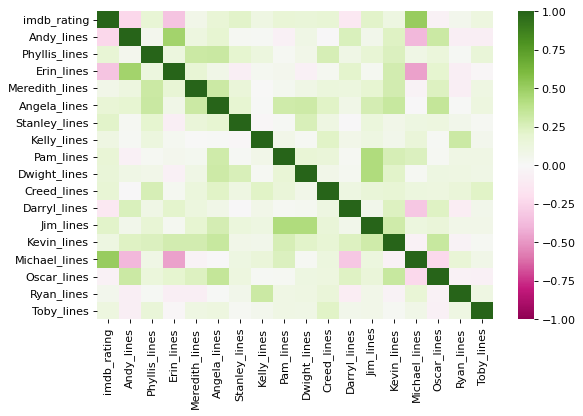

In [41]:
sns.heatmap(all_dummies.loc[:,["imdb_rating", 'Andy_lines', 'Phyllis_lines', 'Erin_lines', 'Meredith_lines',
       'Angela_lines', 'Stanley_lines', 'Kelly_lines', 'Pam_lines',
       'Dwight_lines', 'Creed_lines', 'Darryl_lines', "Jim_lines", "Kevin_lines", 
                                "Michael_lines", "Oscar_lines", "Ryan_lines", "Toby_lines"]].corr(), vmin = -1, vmax = 1,
           cmap = 'PiYG')

In [38]:
dir_corr = all_dummies.loc[:, ["imdb_rating", 'director_Alex Hardcastle', 'director_Amy Heckerling',
       'director_Asaad Kelada', 'director_B.J. Novak',
       'director_Brent Forrester', 'director_Brian Baumgartner',
       'director_Bryan Cranston', 'director_Bryan Gordon',
       'director_Charles McDougall', 'director_Charlie Grandy',
       'director_Claire Scanlon', 'director_Craig Zisk',
       'director_Daniel Chun', 'director_Danny Leiner',
       'director_David Rogers', 'director_Dean Holland',
       'director_Dennie Gordon', 'director_Ed Helms',
       'director_Eric Appel', 'director_Gene Stupnitsky;Lee Eisenberg',
       'director_Greg Daniels', 'director_Harold Ramis',
       'director_J.J. Abrams', 'director_Jason Reitman',
       'director_Jeffrey Blitz', 'director_Jennifer Celotta',
       'director_Jesse Peretz', 'director_John Krasinski',
       'director_John Scott', 'director_Jon Favreau',
       'director_Joss Whedon', 'director_Julian Farino',
       'director_Kelly Cantley-Kashima', 'director_Ken Kwapis',
       'director_Ken Whittingham', 'director_Lee Kirk',
       'director_Marc Webb', 'director_Matt Sohn',
       'director_Michael Spiller', 'director_Miguel Arteta',
       'director_Mindy Kaling', 'director_Paul Feig',
       'director_Paul Lieberstein', 'director_Rainn Wilson',
       'director_Randall Einhorn', 'director_Reginald Hudlin',
       'director_Rodman Flender', 'director_Roger Nygard',
       'director_Seth Gordon', 'director_Seth Gordon;Harold Ramis',
       'director_Stephen Merchant', 'director_Steve Carell',
       'director_Troy Miller', 'director_Tucker Gates',
       'director_Victor Nelli Jr.']].corr()

In [39]:
## Drop all directors with negative correlation with IMDB rating

to_drop = set()

for i in range(len(dir_corr.columns)):
    if (dir_corr.iloc[0, i]) < 0:
        colname = dir_corr.columns[i]
        to_drop.add(colname)

all_dummies = all_dummies.drop(labels = to_drop, axis = 1)


In [34]:
writer_corr = all_dummies.loc[:, ["imdb_rating", 'writer_Aaron Shure',
       'writer_Allison Silverman', 'writer_Amelie Gillette',
       'writer_Anthony Q. Farrell', 'writer_B.J. Novak',
       'writer_Brent Forrester', 'writer_Brent Forrester;Justin Spitzer',
       'writer_Caroline Williams', 'writer_Carrie Kemper',
       'writer_Charlie Grandy', 'writer_Dan Greaney',
       'writer_Dan Sterling', 'writer_Daniel Chun',
       'writer_Daniel Chun;Charlie Grandy',
       'writer_Gene Stupnitsky;Lee Eisenberg', 'writer_Graham Wagner',
       'writer_Greg Daniels', 'writer_Greg Daniels;Mindy Kaling',
       'writer_Halsted Sullivan;Warren Lieberstein',
       'writer_Jason Kessler', 'writer_Jennifer Celotta',
       'writer_Jennifer Celotta;Greg Daniels',
       'writer_Jennifer Celotta;Paul Lieberstein', 'writer_Jon Vitti',
       'writer_Jonathan Green;Gabe Miller', 'writer_Jonathan Huges',
       'writer_Justin Spitzer', 'writer_Larry Willmore',
       'writer_Lee Eisenberg;Gene Stupnitsky;Michael Schur',
       'writer_Lester Lewis', 'writer_Michael Schur',
       'writer_Mindy Kaling', 'writer_Nicki Schwartz-Wright',
       'writer_Owen Ellickson', 'writer_Paul Lieberstein',
       'writer_Paul Lieberstein;Michael Schur', 'writer_Peter Ocko',
       'writer_Ricky Gervais;Stephen Merchant',
       'writer_Ricky Gervais;Stephen Merchant;Greg Daniels',
       'writer_Robert Padnick', 'writer_Ryan Koh', 'writer_Steve Carell',
       'writer_Steve Hely', 'writer_Tim McAuliffe']].corr()

In [35]:
to_drop = set()

for i in range(len(writer_corr.columns)):
    if (writer_corr.iloc[0, i]) < 0:
        colname = writer_corr.columns[i]
        to_drop.add(colname)

all_dummies = all_dummies.drop(labels = to_drop, axis = 1)

In [40]:
all_dummies.head()

,season,episode,episode_name,imdb_rating,total_votes,air_date,n_lines,n_directions,n_words,n_speak_char,...,Jim_lines,Phyllis_lines,Oscar_lines,Angela_lines,Darryl_lines,Andy_lines,Dwight_lines,Toby_lines,Erin_lines,Pam_lines
0,1,1,Pilot,7.6,3706,2005-03-24,229,27,2757,15,...,36.0,2.0,3.0,1.0,0.0,0.0,29.0,0.0,0.0,40.0
1,1,2,Diversity Day,8.3,3566,2005-03-29,203,20,2808,12,...,25.0,0.0,13.0,4.0,0.0,0.0,17.0,2.0,0.0,12.0
2,1,3,Health Care,7.9,2983,2005-04-05,244,21,2769,13,...,42.0,0.0,9.0,5.0,0.0,0.0,62.0,0.0,0.0,32.0
3,1,4,The Alliance,8.1,2886,2005-04-12,243,24,2939,14,...,49.0,5.0,14.0,7.0,0.0,0.0,47.0,4.0,0.0,22.0
4,1,5,Basketball,8.4,3179,2005-04-19,230,49,2437,18,...,21.0,4.0,2.0,3.0,15.0,0.0,25.0,0.0,0.0,14.0


We used correlation to select the directors and writers into the model. Because we want to focus on "What directors/writers can produce better episodes? What directors/writers the team should hire?" rather than "What directors/writers can produce worse episodes? What directors/writers the team should not hire?" We didn't do this on selecting main characters is due to the interaction between them and we wanted to keep these in our model.

#### Calculate the overall sentiment in each episode?

We thought that the sentiment, or the mood of each episode is a key factor of ratings. Hence we conducted the sentiment analysis.

In [41]:
sia = SentimentIntensityAnalyzer()

In [43]:
lines.head()

,season,episode,title,speaker,line,count
0,1,1,Pilot,Michael,All right Jim. Your quarterlies look very good...,1
1,1,1,Pilot,Jim,"Oh, I told you. I couldn't close it. So...",1
2,1,1,Pilot,Michael,So you've come to the master for guidance? Is ...,1
3,1,1,Pilot,Jim,"Actually, you called me in here, but yeah.",1
4,1,1,Pilot,Michael,"All right. Well, let me show you how it's done.",1


In [45]:
for i, j in enumerate(lines.line):
    pol_score = sia.polarity_scores(j)
    lines.loc[i, 'neg'] = pol_score['neg']
    lines.loc[i, 'neu'] = pol_score['neu']
    lines.loc[i, 'pos'] = pol_score['pos']
    lines.loc[i, 'compound'] = pol_score['compound']

In [299]:
lines.head()

,season,episode,title,speaker,line,count,neg,neu,pos,compound
0,1,1,Pilot,Michael,All right Jim. Your quarterlies look very good...,1,0.0,0.803,0.197,0.4927
1,1,1,Pilot,Jim,"Oh, I told you. I couldn't close it. So...",1,0.0,1.000,0.000,0.0000
2,1,1,Pilot,Michael,So you've come to the master for guidance? Is ...,1,0.0,1.000,0.000,0.0000
3,1,1,Pilot,Jim,"Actually, you called me in here, but yeah.",1,0.0,0.714,0.286,0.4215
4,1,1,Pilot,Michael,"All right. Well, let me show you how it's done.",1,0.0,0.811,0.189,0.2732


In [47]:
lines_sent = lines.groupby(['season', 'episode'])[['neg', 'pos']].mean().reset_index()

In [48]:
all_df = pd.merge(left=all_dummies, right=lines_sent, on=['season','episode'], how='left')

In [327]:
all_df.head()

,season,episode,episode_name,imdb_rating,total_votes,air_date,n_lines,n_directions,n_words,n_speak_char,...,Erin_lines,Ryan_lines,Oscar_lines,Dwight_lines,Angela_lines,Meredith_lines,Stanley_lines,Michael_lines,neg,pos
0,1,1,Pilot,7.6,3706,2005-03-24,229,27,2757,15,...,0.0,8.0,3.0,29.0,1.0,0.0,5.0,81.0,0.062285,0.176531
1,1,2,Diversity Day,8.3,3566,2005-03-29,203,20,2808,12,...,0.0,4.0,13.0,17.0,4.0,0.0,5.0,75.0,0.055414,0.234015
2,1,3,Health Care,7.9,2983,2005-04-05,244,21,2769,13,...,0.0,1.0,9.0,62.0,5.0,3.0,6.0,55.0,0.076519,0.155206
3,1,4,The Alliance,8.1,2886,2005-04-12,243,24,2939,14,...,0.0,4.0,14.0,47.0,7.0,10.0,2.0,68.0,0.069584,0.204173
4,1,5,Basketball,8.4,3179,2005-04-19,230,49,2437,18,...,0.0,8.0,2.0,25.0,3.0,0.0,3.0,104.0,0.079322,0.181096


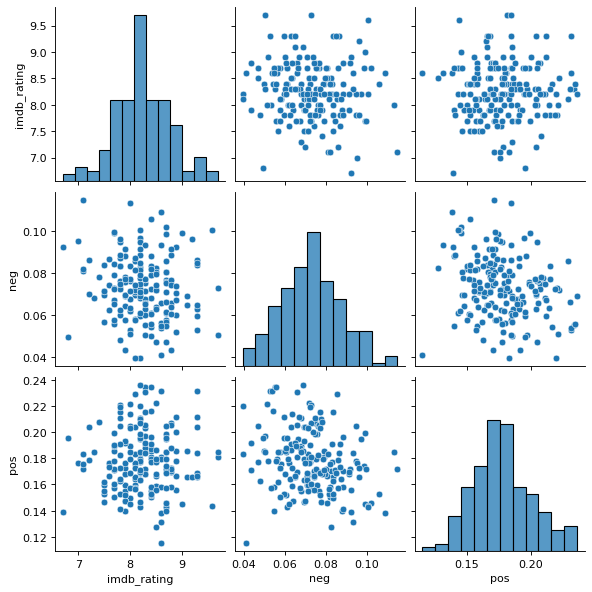

In [328]:
sns.pairplot(all_df[['imdb_rating', 'neg', 'pos']])

In [49]:
all_df[['imdb_rating', 'neg', 'pos']].corr()

,imdb_rating,neg,pos
imdb_rating,1.000000,-0.105865,0.025255
neg,-0.105865,1.000000,-0.252272
pos,0.025255,-0.252272,1.000000


The correlation between the rating and the sentiment of each episode is low. It can be related to the overall style of the series (the sentiment of an comedy series should be positive most of time), or the accuracy of the sentiment analysis [1].

[1] https://towardsdatascience.com/the-best-python-sentiment-analysis-package-1-huge-common-mistake-d6da9ad6cdeb

#### Preparing the final dataset

In [260]:
## Secondary dataset using only most effective writer and director
X_df = all_df[['n_lines', 'n_directions', 'n_speak_char','n_director', 'n_writer', 'n_main_chars', 'Andy_lines', 'Erin_lines',
               'Kevin_lines', 'Pam_lines','Phyllis_lines', 'Toby_lines', 
               'Kelly_lines', 'Jim_lines','Darryl_lines', 'Creed_lines', 'Ryan_lines',
               'Oscar_lines', 'Dwight_lines', 'Angela_lines', 'Meredith_lines',
               'Stanley_lines', 'Michael_lines', 'neg','pos', 'director_Tucker Gates', 'writer_Jennifer Celotta;Paul Lieberstein']]

In [261]:
## intialise the response variable
y = all_df['imdb_rating']

## 3. Model Fitting and Tuning

*In this section you should detail your choice of model and describe the process used to refine and fit that model.*

- You are strongly encouraged to explore many different modeling methods (e.g. linear regression, regression trees, lasso, etc.) but you should not include a detailed narrative of all of these attempts. 
- At most this section should mention the methods explored and why they were rejected - most of your effort should go into describing the model you are using and your process for tuning and validatin it.

*For example if you considered a linear regression model, a classification tree, and a lasso model and ultimately settled on the linear regression approach then you should mention that other two approaches were tried but do not include any of the code or any in depth discussion of these models beyond why they were rejected. This section should then detail is the development of the linear regression model in terms of features used, interactions considered, and any additional tuning and validation which ultimately led to your final model.* 

**This section should also include the full implementation of your final model, including all necessary validation. As with figures, any included code must also be addressed in the text of the document.**

Thing we've tried,

* Add interaction terms of characters -> Doesn't work
* Add director/writer dummy variables -> Doesn't work (even worse)

In [262]:
## separate data into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X_df.values, y.values, test_size=0.2, random_state=50)

<AxesSubplot:ylabel='Count'>

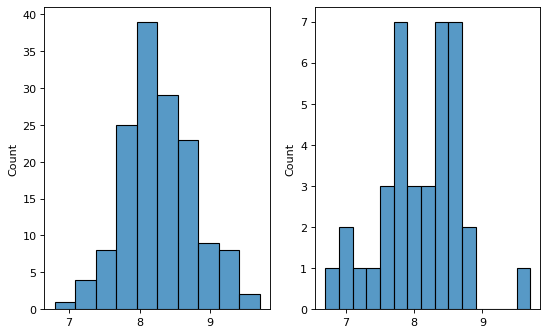

In [263]:
## Check that the training and testing set have similar distributions
fig, ax = plt.subplots(1, 2)
ax= ax.flatten()
sns.histplot(y_train, ax=ax[0])
sns.histplot(y_test, ax=ax[1], binwidth = 0.2)

In [264]:
## Create pipeline for lasso model
pipe = Pipeline([('scaler', StandardScaler()), ('lasso', LassoCV(random_state=50, max_iter=50000))])

In [265]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('lasso', LassoCV(max_iter=50000, random_state=50))])

In [266]:
## R-squared for pipe
pipe.score(X_train, y_train)

0.31503250727283627

In [267]:
y_pred = pipe.predict(X_train)

In [268]:
# Mean squared error for pipe
mean_squared_error(y_train, y_pred)

0.1848721133687426

In [269]:
pipe['lasso'].alpha_

0.05258139422320688

In [270]:
pipe['lasso'].coef_

array([ 0.06883075,  0.00527459,  0.        ,  0.        ,  0.        ,
        0.        , -0.00083673, -0.02571909,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        , -0.        ,
        0.        , -0.        , -0.        ,  0.        ,  0.        ,
        0.        ,  0.01854141,  0.16873147, -0.        , -0.        ,
        0.03786808,  0.01168099])

In [271]:
pipe['lasso'].intercept_

8.279054054054056

In [272]:
lcv_coef = pd.DataFrame(data=pipe['lasso'].coef_, index=X_df.columns, columns=['coef'])

In [273]:
lcv_intercept = pd.DataFrame(data=pipe['lasso'].intercept_, index=['Intercept'], columns=['coef'])

In [274]:
lcv_c = pd.concat([lcv_coef, lcv_intercept])

In [275]:
## Lasso coefficients and magnitude (alpha chosen by cross-validation)
lcv_c.loc[lcv_c.coef != 0, :]

,coef
n_lines,0.068831
n_directions,0.005275
Andy_lines,-0.000837
Erin_lines,-0.025719
Stanley_lines,0.018541
Michael_lines,0.168731
director_Tucker Gates,0.037868
writer_Jennifer Celotta;Paul Lieberstein,0.011681
Intercept,8.279054


In [230]:
cross_validate(pipe, X_train, y_train, scoring=['r2', 'neg_mean_squared_error'])

{'fit_time': array([0.12049723, 0.19304538, 0.19607544, 0.11678386, 0.19714475]),
 'score_time': array([0.00059438, 0.00075221, 0.00055313, 0.00057507, 0.00061154]),
 'test_r2': array([0.21609136, 0.22513632, 0.25120637, 0.16776361, 0.10186217]),
 'test_neg_mean_squared_error': array([-0.17911442, -0.22496015, -0.20064341, -0.22081478, -0.22144811])}

In [235]:
res = y_train - y_pred

Text(0.5, 1.0, 'Residual plot (Residuals vs. Index)')

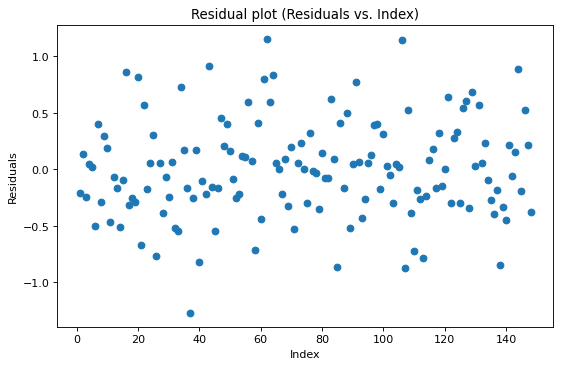

In [238]:
plt.scatter(range(1, len(y_train)+1), res)
plt.xlabel('Index')
plt.ylabel('Residuals')
plt.title('Residual plot (Residuals vs. Index)')

Text(0.5, 1.0, 'Residual plot (Residuals vs. Fitted values)')

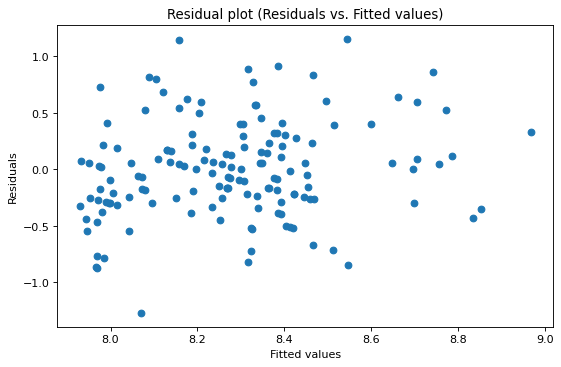

In [239]:
plt.scatter(y_pred, res)
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residual plot (Residuals vs. Fitted values)')

In [240]:
from statsmodels.api import qqplot

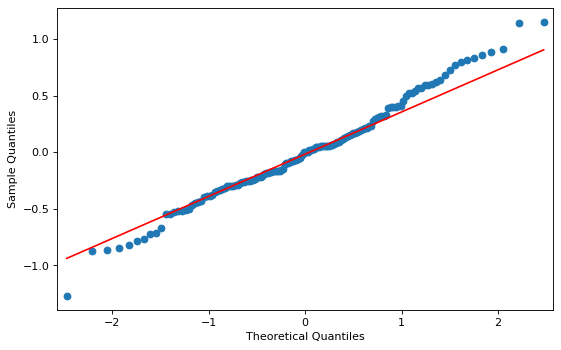

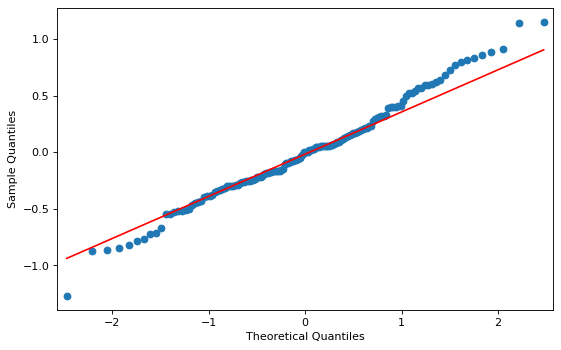

In [241]:
qqplot(res, line='q')

### Validation?

In this case, we emphasized the interpretability of the model. Hence, even though some models such as K-Neighbors Regressor can perform better than Lasso regression in terms of R^2 score and mean square error, we chose the model that is much easy to interpret (it is hard to optimize for the highest possible imdb rating).

For model selection we noticed that n_words and n_lines were extremely highly correlated, so we removed n_words to avoid redundancy (also writing a specific number of words in an episode seems more challenging than writing a specific number of lines, so n_words was a less useful explanatory variable for our purposes). We did an initial lasso fit using all of the directors and writers who we were considering, and then out of the covariates selected by lasso we chose the writer and director with the highest magnitude to consider in our model (we are only interested in conveying which writer and which director are the best, not explaining that certain writers and directors contribute to IMDB score by x amount). We then ran lasso again, with a dataset that only included the most effective writer and the most effective director, to choose our final mdoel.

We also considered average words per line, however the models did not have improved performance in terms of r squared and mean squared error, and words per line is harder to interpret, so we chose to stick with the number of lines model. We decided to look at the number of lines per character, and not which character appears, because if a character has lines they should obviously appear, and determining lines/character seemed more useful, and from our data exploration, seemed mroe highly correlated with imdb rating. 

The lasso method did not choose any of the sentiment analysis data as important for explaining the imdb rating, even though the correlation plot shows that positive sentiment seems weakly correlated with imdb rating. 

## 4. Discussion and Conclusions


*In this section you should provide a general overview of **your final model**, its **performance**, and **reliability**.* 

- You should discuss what the implications of your model are in terms of the included features, predictive performance, and anything else you think is relevant.

- This should be written with a target audience of a NBC Universal executive who is with the show and university level mathematics but not necessarily someone who has taken a postgraduate statistical modeling course. 

- Your goal should be to convince this audience that your model is both accurate and useful.

- Finally, you should include concrete recommendations on what NBC Universal should do to make their reunion episode a popular as possible.

**Keep in mind that a negative result, i.e. a model that does not work well predictively, but that is well explained and justified in terms of why it failed will likely receive higher marks than a model with strong predictive performance but with poor or incorrect explanations / justifications.**

## 5. References

*In this section, you should present a list of external sources (except the course materials) that you used during the project, if any*

- Additional data sources can be cited here, in addition to related python documentations, any other webpage sources that you benefited from

The technique,
https://realpython.com/python-nltk-sentiment-analysis/#installing-and-importing

The dataset(the lines in every episode),
https://www.kaggle.com/code/nilimajauhari/the-office-sentiment-analysis/data